In [4]:
# https://wandb.ai/ayush-thakur/image-segmentation/reports/Image-Segmentation-Using-Keras-and-W-B--VmlldzoyNTE1Njc

# Segmentation with Oxford Pets

In [1]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms as T
from glob import glob


class PetsDataset(object):
    def __init__(self, transforms=None):
        self.transforms = transforms
        
        # keep jpg files and ignore mat files
        fnames = [fname for fname in glob("data/Pets/images/*") if fname.endswith(".jpg")]
        self.imgs = list(sorted(fnames))[:4]
        self.masks = list(sorted(glob("data/Pets/annotations/trimaps/*")))[:4]

    def __getitem__(self, idx):

        img_path = self.imgs[idx]
        mask_path = self.masks[idx]

        img = Image.open(img_path).convert("RGB")
        
        mask = Image.open(mask_path)
        mask = np.array(mask)
        pet_mask = mask == 1  # pets are marked as label 1 (labels are 1=pets, 2, 3=background)
        
        boxes = []
        pos = np.where(pet_mask)  # we want pixels that are True
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # convert everything into a torch.Tensor
        
        # there is only one class since it is background and pet
        labels = torch.ones((1,), dtype=torch.int64)
        
        # create a mask
        masks = torch.as_tensor(pet_mask, dtype=torch.uint8)
        masks = torch.unsqueeze(masks, dim=0)

        # identifyig images, not important
        image_id = torch.tensor([idx])
        
        # compute area for mAP calculations
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)
    
import transforms as T
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        pass
    return T.Compose(transforms)

## Part 2: Instantiate Dataset

In [2]:
dataset = PetsDataset(get_transform(train=True))

In [3]:
record = dataset[2] # 2-element tupe

In [4]:
# look at the original image
img = record[0]  # first element of instance refers to original image
plt.imshow(img.permute(1, 2, 0)), type(img)

NameError: name 'plt' is not defined

### 2b) Inspect Masks


In [7]:
#boxes.append([xmin, ymin, xmax, ymax])
record[1]['boxes']  # second element of record refers to bounding box

tensor([[ 65.,  86., 323., 474.]])

In [8]:
masks = record[1]['masks']
masks.shape

torch.Size([1, 500, 394])

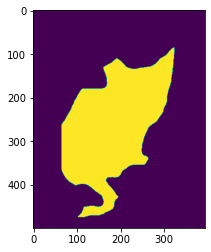

In [9]:
plt.imshow(masks[0])

In [10]:
record[1]['labels']

tensor([1])

## Part 3: Define Model

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, num_classes=2)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## Part 4: Create Dataloader

In [3]:
import utils
import torchvision
import torch

dataset = PetsDataset(get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=utils.collate_fn
)

## Part 5: Instantiate Model

### scenario 1: vanilla modell works with dummy data

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

### scenario 2: modified model works with dummy data too

In [10]:
model = get_model_instance_segmentation(2)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [11]:
predictions[0]['masks'].shape

torch.Size([100, 1, 300, 400])

### secnario 3: vanilla model works with real data
for both eval and training

In [9]:
import utils

dataset = PetsDataset(get_transform(train=True))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

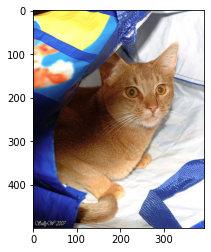

In [15]:
images, targets = next(iter(data_loader))
plt.imshow(images[0].permute(1, 2, 0))

In [20]:
targets[0]['labels']

tensor([1])

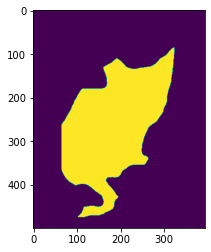

In [19]:
plt.imshow(targets[0]['masks'][0])

In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
model.eval()
predictions = model(images)

### scenario 4: modified model with data

In [4]:
import utils

dataset = PetsDataset(get_transform(train=True))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

In [5]:
images, targets = next(iter(data_loader))
plt.imshow(images[0].permute(1, 2, 0))

NameError: name 'plt' is not defined

In [9]:
torch.stack(images)

RuntimeError: stack expects each tensor to be equal size, but got [3, 313, 450] at entry 0 and [3, 500, 375] at entry 1

In [25]:
model = get_model_instance_segmentation(2)
model.eval()
predictions = model(images)

In [15]:
len(images)

2

In [12]:
model.train()
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

In [13]:
output

{'loss_classifier': tensor(0.7914, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.1537, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0060, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0035, grad_fn=<DivBackward0>)}

In [17]:
losses = sum(loss for loss in output.values())
losses

tensor(0.9546, grad_fn=<AddBackward0>)

In [18]:
losses.item()

0.9545749425888062

# Part 5: Train Loop

In [27]:
from datetime import date

def _save_model(model, optimizer, epoch):
    checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }
    todaysdate = date.today().strftime("%b-%d")
    torch.save(
        checkpoint,
        f'model/{epoch}_{todaysdate}.pt'
        )
    return True

In [28]:
from engine import train_one_epoch, evaluate
import utils
import torch

def main(data_loader, n_epoch, device, checkpoint_path=None):
    
    
    model = get_model_instance_segmentation(num_classes=2)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=0.001,
        momentum=0.9, 
        weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=3,
        gamma=0.1)

    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
        print("Model loaded")

    for epoch in range(n_epoch):
        try:
            train_one_epoch(
                model, 
                optimizer, 
                data_loader, 
                device, 
                epoch, 
                print_freq=1)
            lr_scheduler.step()
        except:
            print('error')
        finally:
            _save_model(model=model, optimizer=optimizer, epoch=epoch)
    print("Completed")

In [29]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')    
n_epoch = 2

dataset = PetsDataset(get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=utils.collate_fn)

main(
    data_loader=data_loader, 
    n_epoch=n_epoch, 
    device=device, 
    checkpoint_path=None
)

Epoch: [0]  [0/2]  eta: 0:01:07  lr: 0.001000  loss: 2.7396 (2.7396)  loss_classifier: 0.6295 (0.6295)  loss_box_reg: 0.0142 (0.0142)  loss_mask: 1.4077 (1.4077)  loss_objectness: 0.6843 (0.6843)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 33.8375  data: 0.0210
Epoch: [0]  [1/2]  eta: 0:00:33  lr: 0.001000  loss: 2.7396 (2.7706)  loss_classifier: 0.6295 (0.6313)  loss_box_reg: 0.0142 (0.0181)  loss_mask: 1.4077 (1.4323)  loss_objectness: 0.6828 (0.6836)  loss_rpn_box_reg: 0.0039 (0.0054)  time: 33.1781  data: 0.0280
Epoch: [0] Total time: 0:01:06 (33.1801 s / it)
Epoch: [1]  [0/2]  eta: 0:01:07  lr: 0.001000  loss: 2.1782 (2.1782)  loss_classifier: 0.6010 (0.6010)  loss_box_reg: 0.0093 (0.0093)  loss_mask: 0.8807 (0.8807)  loss_objectness: 0.6833 (0.6833)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 33.8848  data: 0.0257
Epoch: [1]  [1/2]  eta: 0:00:33  lr: 0.001000  loss: 2.1782 (2.2791)  loss_classifier: 0.5718 (0.5864)  loss_box_reg: 0.0093 (0.0117)  loss_mask: 0.8807 (0.9936)  loss_obje

# Part 6: Inference
* https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae

In [30]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, num_classes=2)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [31]:
from PIL import ImageDraw
import torch
import utils

In [32]:
dataset = PetsDataset(get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=utils.collate_fn)

In [34]:
model = get_model_instance_segmentation(num_classes=2)
checkpoint = torch.load('model/1_Apr-03.pt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [35]:
images, _ = next(iter(data_loader))
len(images)

1

In [36]:
model.eval()
prediction = model(images)

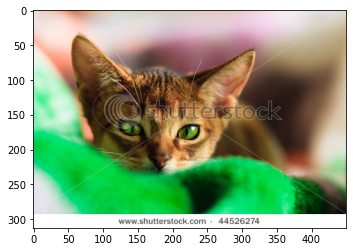

In [38]:
# inspect original image
idx = 0

plt.imshow(images[idx].permute(1, 2, 0))

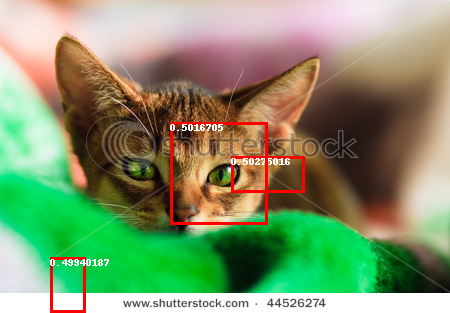

In [39]:
image = Image.fromarray(images[idx].mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(image)

predicted_boxes = prediction[idx]['boxes']
predicted_scores = prediction[idx]['scores']

n_boxes = len(predicted_boxes)  # number of predicted boxes
top_k = 3

for e in range(n_boxes)[:top_k]:
    b = predicted_boxes[e].detach().numpy()
    s = predicted_scores[e].detach().numpy()
    draw.rectangle([(b[0], b[1]), (b[2], b[3])], outline ="red", width=3)
    draw.text((b[0], b[1]), text = str(s))
image

In [211]:
m1 = prediction[0]['masks'][1].detach().numpy() > 0
m2 = m1.astype(int)
plt.imshow(m2[0, :,:])